In [2]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('/PhD/rehabilitation/小论文/论文3/同济坐站角度相位预测')
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt
from utilss.common_utils import make_dir

In [3]:
##直接微分计算角速度，会丢失一个点,输入关心的起止时间（单位秒）
def straightAngleVelocity(fuyangAngle,startTime,endTime):
    timeArrya = fuyangAngle[:,0]
    angleArray = fuyangAngle[:,1]
    sangleArray = angleArray[0:-1]
    eangleArray = angleArray[1:]
    dt = 1/fs
    dangleArray =(eangleArray-sangleArray)/dt
    start = int(startTime*fs)
    end   = int(endTime*fs)
    return timeArrya[start:end],dangleArray[start:end]
#函数返回对应的时间段和角速度

#先插值，然后在采样点位置求曲线斜率获得角速度
def splineAngleVelocity(fuyangAngle,startTime,endTime):
    timeArrya = fuyangAngle[:,0]
    angleArray = fuyangAngle[:,1]
    start = int(startTime*fs)
    end   = int(endTime*fs)
    x = timeArrya  # 采样点的位置
    y = angleArray  # 采样点对应的数值
    # 创建插值函数
    interpolation_func = InterpolatedUnivariateSpline(x, y)
    # 创建新的采样点
    new_x = timeArrya[start:end]  # 用于插值的新采样点
    # 在新采样点上进行插值
    new_y = interpolation_func(new_x)
    # 完成拟合后，可以对 new_y 进行求导数
    derivative = np.gradient(new_y, new_x)
    return new_x,derivative
#函数返回对应的时间段和角速度
# 寻找曲线与 y=a 直线相交的 x
def get_x_values(x, y, a):
    x_intersections = []
    for i in range(len(x) - 1):
        if (y[i] - a) * (y[i + 1] - a) < 0:
            x_intersections.append(np.interp(a, [y[i], y[i + 1]], [x[i], x[i + 1]]))
    return x_intersections
# 寻找曲线与 x=a 直线相交的唯一 y 值
def get_y_values(x, y, a):
    y_intersection = None
    for i in range(len(x) - 1):
        if (x[i] - a) == 0:
            y_intersection = np.interp(a, [x[i], x[i + 1]], [y[i], y[i + 1]])
            break
        elif (x[i] - a) * (x[i + 1] - a) < 0:
            y_intersection = np.interp(a, [x[i], x[i + 1]], [y[i], y[i + 1]])
            break
    if y_intersection is None:
        raise ValueError('error!')
    return y_intersection
def get_subject_and_limbs(subjects_list_global, normal_limbs, abnormal_limbs, subject_order):
    sub = subjects_list_global[subject_order]
    sub_normal_limb = normal_limbs[subject_order]
    sub_abnormal_limb = abnormal_limbs[subject_order]
    sub_normal_limb_eng = 'left' if sub_normal_limb == '左' else 'right'
    sub_abnormal_limb_eng = 'left' if sub_abnormal_limb == '左' else 'right'
    return sub, sub_normal_limb, sub_abnormal_limb, sub_normal_limb_eng, sub_abnormal_limb_eng

In [4]:
##数据格式：1，time；2-17，sEMG；18-23，髋膝踝角度；24 骨盆倾角
subject_order =3  ##从0开始，即第1个受试者
fs = 200
# subjects_list_global = list(['EgP-1-2'])
subjects_list_global = list(['EgP-1-2','EgP-2-2','EgP-3-2','EgP-4-2'])
# EGPnormalLimb = ['左','左','左','左','左','左','左']
# subjects_list_global =list( ['EgH-1','EgH-2','EgH-3','EgH-4','EgH-5','EgH-6','EgH-7'])

EGPnormalLimb = ['左','左','左','右','左','右','左']
EGPabnormalLimb = ['右','右','右','左','右','左','右']
subject, subject_normal_limb, subject_abnormal_limb, subject_normal_limb_eng, subject_abnormal_limb_eng = get_subject_and_limbs(subjects_list_global, EGPnormalLimb, EGPabnormalLimb, subject_order)
print(subject_abnormal_limb,subject_normal_limb_eng)

raw_file_path = os.path.join(os.getcwd(), 'TJRawData', 'rawData_npz')
file_name = os.path.join(raw_file_path, subject+'.npz')
print(file_name)
# 加载 .npz 文件
data = np.load(file_name, allow_pickle=True)
# 获取保存的数组和列名
data_array = data['data']
data_array = data_array[::10]
column_names = data['column_names']
print(column_names)
save_path = r'E:\PhD\rehabilitation\小论文\论文3\同济数据处理\preProcessing\TJRawData\Activate points-phase'
# save_path = os.path.join(save_path, 'Normal')
make_dir(save_path)

左 right
E:\PhD\rehabilitation\小论文\论文3\同济坐站角度相位预测\preProcessing\TJRawData\rawData_npz\EgP-4-2.npz
['Time,s' 'GLUT. MED. 左,uV' 'VMO 左,uV' 'RECTUS FEM. 左,uV'
 'RECTUS FEM. 右,uV' 'BICEPS FEM. 左,uV' 'BICEPS FEM. 右,uV' 'VMO 右,uV'
 'SEMITEND. 右,uV' 'TIB.ANT. 左,uV' 'TIB.ANT. 右,uV' 'MED. GASTRO 左,uV'
 'MED. GASTRO 右,uV' 'SOLEUS 左,uV' 'SOLEUS 右,uV' 'GLUT. MED. 右,uV'
 'SEMITEND. 左,uV' '髋关节屈曲 左,deg' '髋关节屈曲 右,deg' '膝关节屈曲 左,deg' '膝关节屈曲 右,deg'
 '踝关节背屈 左,deg' '踝关节背屈 右,deg' '骨盆 course,deg' '骨盆 pitch,deg' '骨盆 roll,deg'
 '大腿 course 左,deg' '大腿 pitch 左,deg' '大腿 roll 左,deg' '胫骨 course 左,deg'
 '胫骨 pitch 左,deg' '胫骨 roll 左,deg' '脚 course 左,deg' '脚 pitch 左,deg'
 '脚 roll 左,deg' '大腿 course 右,deg' '大腿 pitch 右,deg' '大腿 roll 右,deg'
 '胫骨 course 右,deg' '胫骨 pitch 右,deg' '胫骨 roll 右,deg' '骨盆 Rot X,'
 '骨盆 Rot Y,' '骨盆 Rot Z,']


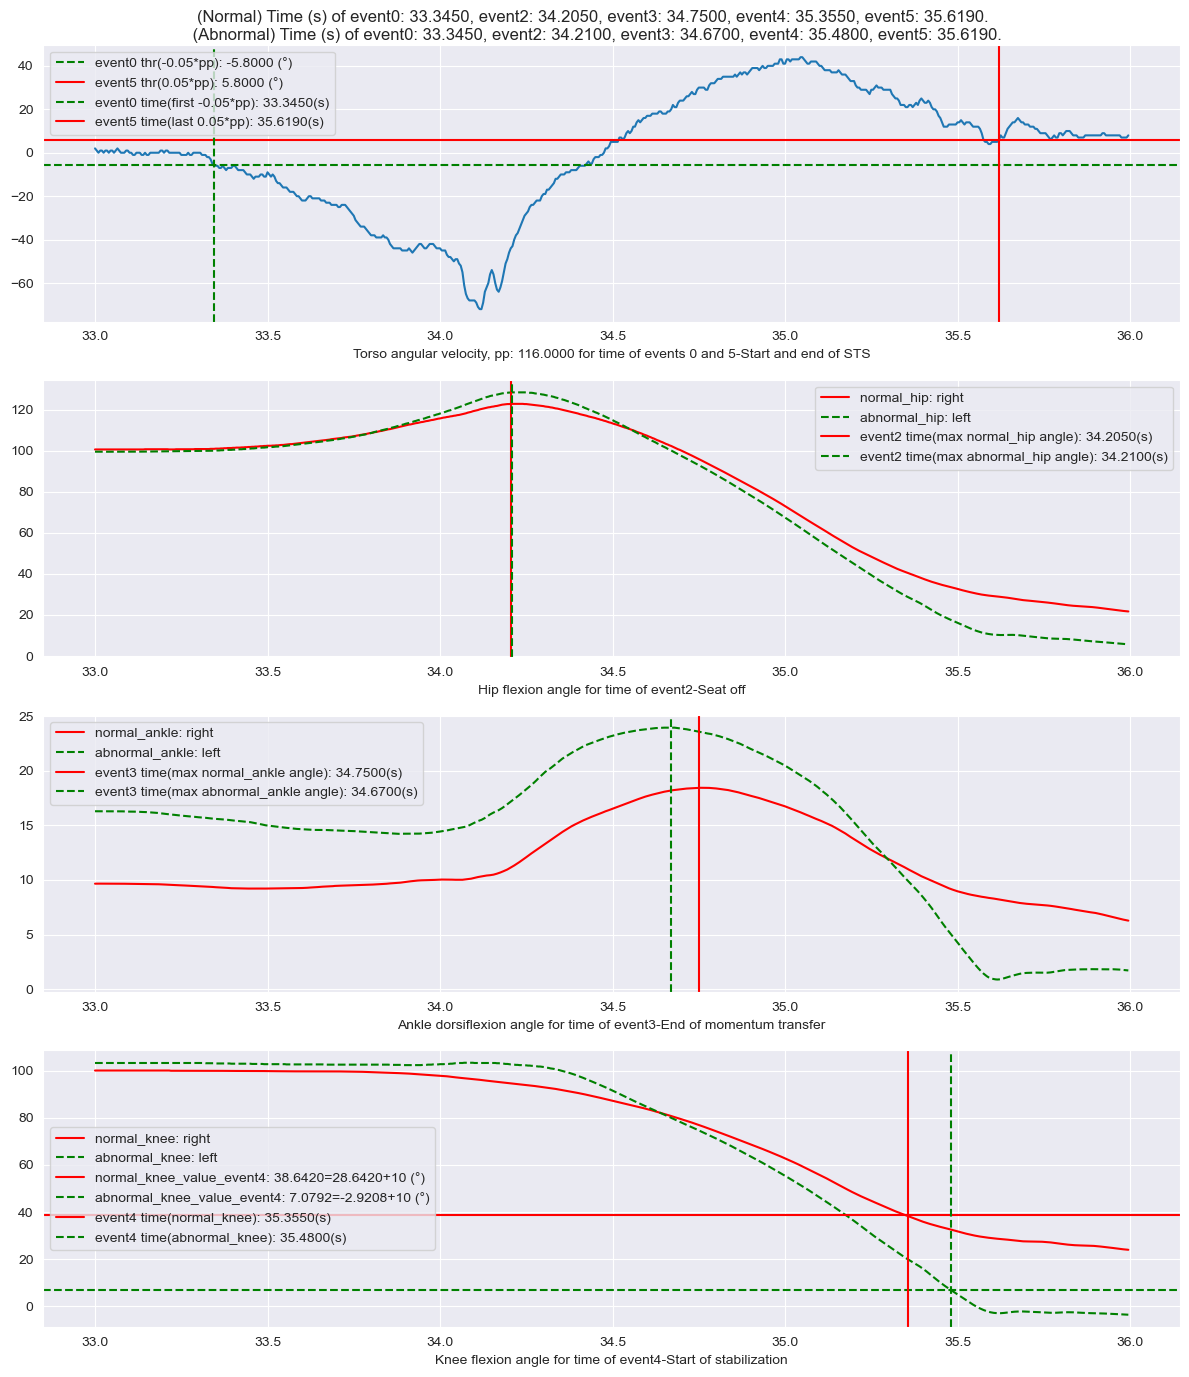

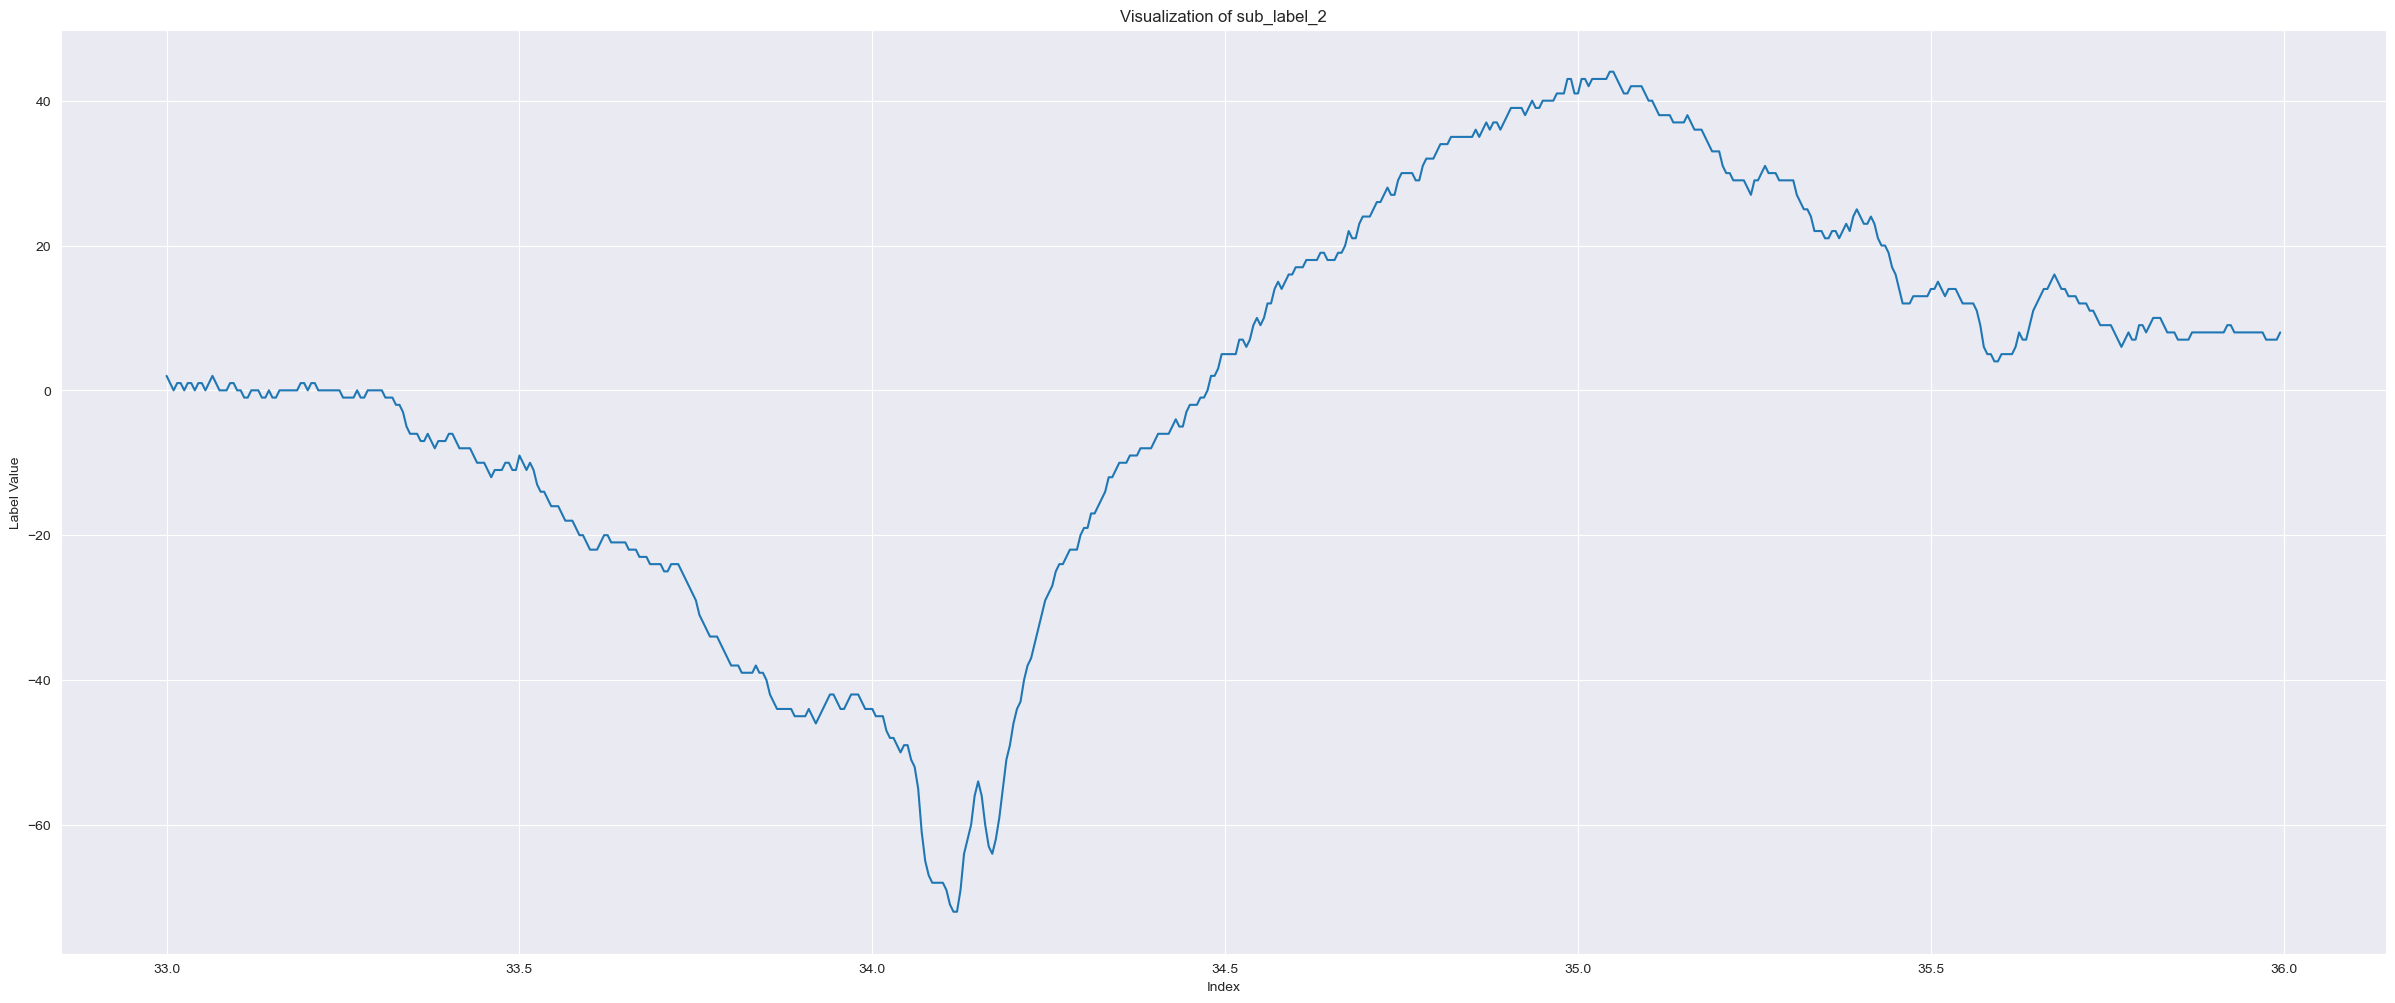

In [9]:
# event 0: start of STS: -5*躯干角速度的峰峰值(pp)
# event 2: seat-off: 髋关节角度达到最大值的点
# event 3: end of momentum transfer: 踝关节角度达到最大值的点
# event 4: Start of stabilization 膝关节角度=膝关节角度（event 5）- 10的点
# event 5: end of sts: 5*躯干角速度的峰峰值(pp)
import matplotlib.ticker as ticker
startTime = 33
endTime   = 36
fig_save_name = os.path.join(save_path, 'STS-Phase-1.jpg')
start = int(startTime*fs)
end   = int(endTime*fs)
# 计算躯干俯仰角，得到event 0和event 5时间点
fuyangAngle = data_array[:,[0, 24]]
#优点比较明显，曲线平滑，趋势一致，便于找到10度点
time, gradient = splineAngleVelocity(fuyangAngle,startTime,endTime)
peak_to_peak = np.ptp(gradient)
fig, axes = plt.subplots(4, 1, figsize=(12, 14))
ax0 = axes[0]
ax0.plot(time, gradient)
ax0.set_xlabel('Torso angular velocity, pp: %.4f for time of events 0 and 5-Start and end of STS'% peak_to_peak)
event0_value = -0.05*peak_to_peak
event0_times = get_x_values(time, gradient, event0_value)
event0_time = event0_times[0]
event5_value = 0.05*peak_to_peak
event5_times = get_x_values(time, gradient, event5_value)
event5_time = event5_times[-1]
ax0.axhline(y=event0_value, color='green', linestyle='--', label='event0 thr(-0.05*pp): %.4f (°)'%event0_value)
ax0.axhline(y=event5_value, color='red', label='event5 thr(0.05*pp): %.4f (°)'%event5_value)
ax0.axvline(x=event0_time, color='green', linestyle='--', label='event0 time(first -0.05*pp): %.4f(s)'%event0_time)
ax0.axvline(x=event5_time, color='red', label='event5 time(last 0.05*pp): %.4f(s)'%event5_time)
ax0.legend()
ax0.grid(True)
# event 2: seat-off: 髋关节角度达到最大值的点
time = data_array[start:end, 0]   # 时间
normal_hip = data_array[start:end, 17]   #左髋关节角度
abnormal_hip = data_array[start:end, 18] #右髋关节角度
ax1 = axes[1]
ax1.plot(time, normal_hip, 'r', label='normal_hip: %s'%subject_normal_limb_eng)
ax1.plot(time, abnormal_hip, 'g', linestyle='--', label='abnormal_hip: %s'%subject_abnormal_limb_eng)
ax1.set_xlabel('Hip flexion angle for time of event2-Seat off')
normal_hip_max_y_index = np.argmax(normal_hip)
normal_hip_max_x = time[normal_hip_max_y_index]
abnormal_hip_max_y_index = np.argmax(abnormal_hip)
abnormal_hip_max_x = time[abnormal_hip_max_y_index]
ax1.axvline(x=normal_hip_max_x, color='red', label='event2 time(max normal_hip angle): %.4f(s)'%normal_hip_max_x)
ax1.axvline(x=abnormal_hip_max_x, color='green', linestyle='--',  label='event2 time(max abnormal_hip angle): %.4f(s)'%abnormal_hip_max_x)
ax1.legend()
ax1.grid(True)
# event 3: end of momentum transfer: 踝关节角度达到最大值的点
time =  data_array[start:end, 0]   # 时间
normal_ankle =  data_array[start:end, 21]   #左踝关节角度
abnormal_ankle = data_array[start:end, 22]   #右踝关节角度
ax2 = axes[2]
ax2.plot(time, normal_ankle, 'r', label='normal_ankle: %s'%subject_normal_limb_eng)
ax2.plot(time, abnormal_ankle, 'g', linestyle='--', label='abnormal_ankle: %s'%subject_abnormal_limb_eng)
ax2.set_xlabel('Ankle dorsiflexion angle for time of event3-End of momentum transfer')
normal_ankle_max_y_index = np.argmax(normal_ankle)
normal_ankle_max_x = time[normal_ankle_max_y_index]
abnormal_ankle_max_y_index = np.argmax(abnormal_ankle)
abnormal_ankle_max_x = time[abnormal_ankle_max_y_index]
ax2.axvline(x=normal_ankle_max_x, color='red', label='event3 time(max normal_ankle angle): %.4f(s)'%normal_ankle_max_x)
ax2.axvline(x=abnormal_ankle_max_x, color='green', linestyle='--',  label='event3 time(max abnormal_ankle angle): %.4f(s)'%abnormal_ankle_max_x)
ax2.legend()
ax2.grid(True)
# 设置 x 轴和 y 轴的主刻度和次刻度
# ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.125))  # 主刻度
# ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))  # 主刻度
# ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))   # 次刻度，每个主刻度之间有两个次刻度
# ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))   # 次刻度，每个主刻度之间有两个次刻度

# event 4: Start of stabilization 膝关节角度=膝关节角度（event 5）- 10的点
time =  data_array[start:end, 0]   # 时间
normal_knee = data_array[start:end, 19]   #左膝关节角度
abnormal_knee= data_array[start:end, 20]   #右膝关节角度
ax3 = axes[3]
ax3.plot(time, normal_knee, 'r', label='normal_knee: %s'%subject_normal_limb_eng)
ax3.plot(time, abnormal_knee, 'g', linestyle='--', label='abnormal_knee: %s'%subject_abnormal_limb_eng)
ax3.set_xlabel('Knee flexion angle for time of event4-Start of stabilization')
# 先获得event5时的y值
normal_knee_value_event5 = get_y_values(time, normal_knee, event5_time)
normal_knee_value_event4 = normal_knee_value_event5 + 10
normal_knee_times_event4 = get_x_values(time, normal_knee, normal_knee_value_event4)
normal_knee_time_event4 = normal_knee_times_event4[-1]
abnormal_knee_value_event5 = get_y_values(time, abnormal_knee, event5_time)
abnormal_knee_value_event4 = abnormal_knee_value_event5 + 10
abnormal_knee_times_event4 = get_x_values(time, abnormal_knee, abnormal_knee_value_event4)
abnormal_knee_time_event4 = abnormal_knee_times_event4[-1]
ax3.axhline(y=normal_knee_value_event4, color='red', label='normal_knee_value_event4: %.4f=%.4f+10 (°)'%(normal_knee_value_event4, normal_knee_value_event5))
ax3.axhline(y=abnormal_knee_value_event4, color='green', linestyle='--', label='abnormal_knee_value_event4: %.4f=%.4f+10 (°)'%(abnormal_knee_value_event4, abnormal_knee_value_event5))
ax3.axvline(x=normal_knee_time_event4, color='red', label='event4 time(normal_knee): %.4f(s)'%normal_knee_time_event4)
ax3.axvline(x=abnormal_knee_time_event4, color='green', linestyle='--',  label='event4 time(abnormal_knee): %.4f(s)'%abnormal_knee_time_event4)
ax3.legend()
ax3.grid(True)
plt.suptitle('(Normal) Time (s) of event0: %.4f, event2: %.4f, event3: %.4f, event4: %.4f, event5: %.4f. \n '
             '(Abnormal) Time (s) of event0: %.4f, event2: %.4f, event3: %.4f, event4: %.4f, event5: %.4f.'%(event0_time, normal_hip_max_x, normal_ankle_max_x,  normal_knee_time_event4, event5_time, event0_time, abnormal_hip_max_x, abnormal_ankle_max_x,   abnormal_knee_time_event4, event5_time))
plt.tight_layout()  
# plt.savefig(fig_save_name, dpi=300)
plt.show()
# 1. 获取时间数据
time = data_array[start:end, 0]  # 假设第 0 列是时间列

# 2. 获取左膝关节角度数据，假设这些列索引是正确的
# 这里我们使用切片方式来选择多个列
columns = [24, 18, 17, 22, 21, 20, 19]  # 选择你需要的列
data = data_array[start:end, columns]  # 获取这些列的数据

# 3. 将时间和数据水平堆叠
ndata = np.hstack([time[:, np.newaxis], data])  # 添加 np.newaxis 将 time 转换为列向量

# 4. 修改 ndata 第一列的数据
t = ndata[:, 0]  # 修改时间数据
# 对时间列进行线性映射：将时间从 [0, 3] 映射到 [0, 100]
# time_new = (time - 0) / (t  - 0) * (100 - 0) + 0

# 更新 ndata 中的时间列
ndata[:, 0] = t
ndata[:,1] = gradient
# print(time_new[0-5])
# 创建一个简单的条形图
plt.figure(figsize=(30, 12))
plt.plot(ndata[:, 0], ndata[:,1] )

# 设置图形的标题和标签
plt.title("Visualization of sub_label_2")
plt.xlabel("Index")
plt.ylabel("Label Value")

# 显示图形
plt.show()
# ndata 现在是你需要的数据
# 将 ndata 转换为 pandas DataFrame
df = pd.DataFrame(ndata)  # 如果有多列，可以按顺序命名

# 将 DataFrame 保存到 CSV 文件
df.to_csv('STS-phase-EgP-4.csv', index=False)


In [10]:
# 保存文件
# Metrics = {'event0_time':event0_time, 'event2_time':abnormal_hip_max_x, 'event3_time':abnormal_ankle_max_x,
#             'event4_time':abnormal_knee_time_event4, 'event5_time':event5_time}
Metrics = [[event0_time], [abnormal_hip_max_x], [abnormal_ankle_max_x],
            [abnormal_knee_time_event4], [event5_time]]
Path = r'E:\PhD\rehabilitation\小论文\论文3\同济坐站角度相位预测\preProcessing\TJRawData\Activate points-phase\Abnormal'
if not os.path.exists(Path):
    os.makedirs(Path)
MetricsName = os.path.join(Path,''.join([subject,'-sittostand.xlsx']))
if os.path.isfile(MetricsName):
    print('文件已存在')
    oldMetrics= pd.read_excel(MetricsName, header=None)#dtype='str'
    newMetrics=pd.DataFrame(Metrics).T
    result = pd.concat([oldMetrics, newMetrics], axis=0)
    # Metrics=Metrics.append(newMetrics)#,ignore_index=True
    result.to_excel(MetricsName, index=False, header=None)#"utf_8_sig"
else:
    print('文件不存在')
    Metrics=pd.DataFrame(Metrics).T
    Metrics.to_excel(MetricsName, index=False, header=None)
    
Metrics = [[event0_time], [normal_hip_max_x], [normal_ankle_max_x],
            [normal_knee_time_event4], [event5_time]]
Path = r'E:\PhD\rehabilitation\小论文\论文3\同济坐站角度相位预测\preProcessing\TJRawData\Activate points-phase\Normal'
if not os.path.exists(Path):
    os.makedirs(Path)
MetricsName = os.path.join(Path,''.join([subject,'-sittostand.xlsx']))
if os.path.isfile(MetricsName):
    print('文件已存在')
    oldMetrics= pd.read_excel(MetricsName, header=None)#dtype='str'
    newMetrics=pd.DataFrame(Metrics).T
    result = pd.concat([oldMetrics, newMetrics], axis=0)
    # Metrics=Metrics.append(newMetrics)#,ignore_index=True
    result.to_excel(MetricsName, index=False, header=None)#"utf_8_sig"
else:
    print('文件不存在')
    Metrics=pd.DataFrame(Metrics).T
    Metrics.to_excel(MetricsName, index=False, header=None)

文件已存在
文件已存在
